<a href="https://colab.research.google.com/github/ArmandoGalaz/prueba/blob/main/Modelo_con_ADASYN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Modelo Híbrido CNN-BiLSTM con Atención para Detección de Fake News

# Modelo Híbrido CNN-BiLSTM con Mecanismo de Atención para Detección de Fake News

 Este notebook implementa un modelo para detección de noticias falsas utilizando:
 - **Capas Conv1D** para extracción de características locales
 - **BiLSTM** para capturar dependencias secuenciales a largo plazo
 - **Embeddings pre-entrenados** (RoBERTa) como entrada


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install tensorflow numpy pandas scikit-learn matplotlib imblearn

## Configuración del Entorno

In [ ]:
!pip install optuna

In [ ]:
!pip install optuna-integration[tfkeras]

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import ADASYN
from collections import Counter
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')
# Nuevas importaciones para optimización bayesiana
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
import logging

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

## Carga y Preprocesamiento de Datos

 Cargamos:
 1. Embeddings vectorizados (.npy)
 2. Metadatos con etiquetas (.json)

In [ ]:
# Cargar embeddings preprocesados
embeddings = np.load('/content/drive/Shareddrives/Titulo 2/Dataset/Vectorizaciones/roberta_base_results_vectors.npy')
# Reshape embeddings to be 3D (num_samples, sequence_length, embedding_dim)
embeddings = embeddings[:, np.newaxis, :]
print(f"Forma de los embeddings: {embeddings.shape}")

Forma de los embeddings: (2075, 1, 768)


In [ ]:
with open('/content/drive/Shareddrives/Titulo 2/Dataset/unique_labels.json', 'r') as f:
    unique_labels_data = json.load(f)

# Obtener categorías de etiquetas
categorias_etiquetas = unique_labels_data['Categoría']  # ['FALSO', 'VERDADERO']

# Mapeo de etiquetas a números: FALSO -> 0, VERDADERO -> 1
mapeo_etiquetas = {categoria: i for i, categoria in enumerate(categorias_etiquetas)}

# Cargar el DataFrame original (ajustar la ruta según tu estructura)
df = pd.read_csv('/content/drive/Shareddrives/Titulo 2/Dataset/dataset.csv')

# Convertir etiquetas a números usando el mapeo
labels = df['Categoría'].map(mapeo_etiquetas).values

print(f"\nDistribución de etiquetas original:")
original_distribution = pd.Series(labels).value_counts().sort_index()
print(original_distribution)
print(f"Ratio de desbalance: {original_distribution.max() / original_distribution.min():.2f}:1")



Distribución de etiquetas original:
0    1424
1     651
Name: count, dtype: int64
Ratio de desbalance: 2.19:1


In [ ]:
# División inicial estratificada
X_temp, X_test, y_temp, y_test = train_test_split(
    embeddings,
    labels,
    test_size=0.10,
    stratify=labels,
    random_state=100
)

X_train_raw, X_val, y_train_raw, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=1/9,
    stratify=y_temp,
    random_state=100
)

In [ ]:
print(f"\nConjuntos ANTES de ADASYN:")
print(f"Entrenamiento: {X_train_raw.shape}, distribución: {Counter(y_train_raw)}")
print(f"Validación: {X_val.shape}, distribución: {Counter(y_val)}")
print(f"Prueba: {X_test.shape}, distribución: {Counter(y_test)}")


Conjuntos ANTES de ADASYN:
Entrenamiento: (1659, 1, 768), distribución: Counter({np.int64(0): 1138, np.int64(1): 521})
Validación: (208, 1, 768), distribución: Counter({np.int64(0): 143, np.int64(1): 65})
Prueba: (208, 1, 768), distribución: Counter({np.int64(0): 143, np.int64(1): 65})


## Construcción del Modelo

Implementación de la arquitectura:
 1. Capas de entrada para embeddings
 2. CNN 1D para características locales
 3. BiLSTM para dependencias secuenciales
 4. Mecanismo de atención para interpretabilidad
 5. Capas densas para clasificación

In [ ]:
def apply_adasyn_to_embeddings(X_train, y_train, random_state=100):
    """
    Aplica ADASYN para balancear clases en embeddings 3D de manera robusta

    Args:
        X_train: Embeddings de entrenamiento (n_samples, seq_len, embed_dim)
        y_train: Labels de entrenamiento
        random_state: Semilla para reproducibilidad

    Returns:
        X_balanced, y_balanced: Datos balanceados
    """

    # Guardar forma original para reshape posterior
    original_shape = X_train.shape

    # Flatten embeddings para ADASYN (requiere 2D)
    X_flat = X_train.reshape(X_train.shape[0], -1)

    print(f"\n{'='*60}")
    print(f"APLICANDO ADASYN PARA BALANCEO DE CLASES")
    print(f"{'='*60}")
    print(f"Forma original de embeddings: {original_shape}")
    print(f"Forma de embeddings aplanados: {X_flat.shape}")
    print(f"Distribución original: {Counter(y_train)}")

    # Calcular ratio de desbalance inicial
    class_counts = Counter(y_train)
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)
    imbalance_ratio = class_counts[majority_class] / class_counts[minority_class]

    print(f"Clase mayoritaria: {majority_class} ({class_counts[majority_class]} muestras)")
    print(f"Clase minoritaria: {minority_class} ({class_counts[minority_class]} muestras)")
    print(f"Ratio de desbalance: {imbalance_ratio:.2f}:1")

    # Verificar si es necesario aplicar ADASYN
    if imbalance_ratio < 1.5:
        print("⚠️  Dataset relativamente balanceado. ADASYN puede no ser necesario.")
        return X_train, y_train

    # Configurar ADASYN con parámetros optimizados
    try:
        adasyn = ADASYN(
            sampling_strategy='auto',  # Balancea automáticamente todas las clases
            n_neighbors=min(5, class_counts[minority_class] - 1),  # Ajustar según datos disponibles
            random_state=random_state,
        )

        print(f"Configuración ADASYN:")
        print(f"- Estrategia de muestreo: auto")
        print(f"- Número de vecinos: {adasyn.n_neighbors}")
        print(f"- Semilla aleatoria: {random_state}")

        # Aplicar ADASYN
        print("\n🔄 Aplicando ADASYN...")
        X_balanced_flat, y_balanced = adasyn.fit_resample(X_flat, y_train)

        # Reshape de vuelta a forma 3D original
        X_balanced = X_balanced_flat.reshape(-1, original_shape[1], original_shape[2])

        # Estadísticas post-ADASYN
        balanced_counts = Counter(y_balanced)
        synthetic_samples = len(y_balanced) - len(y_train)

        print(f"\n✅ ADASYN aplicado exitosamente!")
        print(f"Distribución después de ADASYN: {balanced_counts}")
        print(f"Muestras originales: {len(y_train)}")
        print(f"Muestras sintéticas añadidas: {synthetic_samples}")
        print(f"Total de muestras: {len(y_balanced)}")

        # Cálculo de mejora para clase minoritaria
        original_minority_count = class_counts[minority_class]
        new_minority_count = balanced_counts[minority_class]
        improvement_percent = ((new_minority_count / original_minority_count) - 1) * 100

        # Nuevo ratio de balance
        new_imbalance_ratio = max(balanced_counts.values()) / min(balanced_counts.values())

        print(f"\n📊 ESTADÍSTICAS DE MEJORA:")
        print(f"Clase minoritaria original: {original_minority_count} muestras")
        print(f"Clase minoritaria balanceada: {new_minority_count} muestras")
        print(f"Incremento: {improvement_percent:.1f}%")
        print(f"Ratio de desbalance original: {imbalance_ratio:.2f}:1")
        print(f"Ratio de desbalance final: {new_imbalance_ratio:.2f}:1")
        print(f"Mejora en balance: {((imbalance_ratio / new_imbalance_ratio) - 1) * 100:.1f}%")

        # Verificar integridad de los datos
        assert X_balanced.shape[1:] == original_shape[1:], "Error: Las dimensiones no coinciden"
        assert len(X_balanced) == len(y_balanced), "Error: Mismatch entre features y labels"

        print(f"\n✅ Verificación de integridad: EXITOSA")
        print(f"Forma final de embeddings: {X_balanced.shape}")

        return X_balanced, y_balanced

    except ValueError as e:
        if "n_neighbors" in str(e):
            print(f"⚠️  Error con n_neighbors: {e}")
            print("Intentando con n_neighbors reducido...")

            # Reintentar con menos vecinos
            min_neighbors = max(1, min(class_counts.values()) - 1)
            adasyn_reduced = ADASYN(
                sampling_strategy='auto',
                n_neighbors=min_neighbors,
                random_state=random_state
            )

            X_balanced_flat, y_balanced = adasyn_reduced.fit_resample(X_flat, y_train)
            X_balanced = X_balanced_flat.reshape(-1, original_shape[1], original_shape[2])

            print(f"✅ ADASYN aplicado con n_neighbors={min_neighbors}")
            print(f"Distribución final: {Counter(y_balanced)}")

            return X_balanced, y_balanced

    except Exception as e:
        print(f"❌ Error inesperado aplicando ADASYN: {e}")
        print("Usando datos originales sin balancear")
        print("Considera usar técnicas alternativas como class_weight en el modelo")
        return X_train, y_train

In [ ]:
def calculate_class_weights(y_train):
    """
    Calcula pesos de clase para usar como alternativa/complemento a ADASYN
    """
    class_counts = Counter(y_train)
    total_samples = len(y_train)
    n_classes = len(class_counts)

    # Calcular pesos inversamente proporcionales a la frecuencia
    class_weights = {}
    for class_label, count in class_counts.items():
        class_weights[class_label] = total_samples / (n_classes * count)

    print(f"\n📊 PESOS DE CLASE CALCULADOS:")
    for class_label, weight in class_weights.items():
        print(f"Clase {class_label}: {weight:.4f}")

    return class_weights

In [ ]:
# Función principal para aplicar el balanceo completo
def balance_training_data(X_train_raw, y_train_raw, use_adasyn=True, random_state=100):
    """
    Función principal para balancear datos de entrenamiento

    Args:
        X_train_raw: Datos de entrenamiento sin balancear
        y_train_raw: Etiquetas sin balancear
        use_adasyn: Si usar ADASYN (True) o solo calcular pesos (False)
        random_state: Semilla para reproducibilidad

    Returns:
        X_train, y_train, class_weights: Datos balanceados y pesos de clase
    """

    print(f"🚀 INICIANDO PROCESO DE BALANCEO DE DATOS")
    print(f"Estrategia: {'ADASYN + Class Weights' if use_adasyn else 'Solo Class Weights'}")

    # Calcular pesos de clase (siempre útil)
    class_weights = calculate_class_weights(y_train_raw)

    if use_adasyn:
        # Aplicar ADASYN
        X_train, y_train = apply_adasyn_to_embeddings(X_train_raw, y_train_raw, random_state)

        # Recalcular pesos después de ADASYN (pueden cambiar ligeramente)
        if len(y_train) != len(y_train_raw):
            print("\n🔄 Recalculando pesos de clase después de ADASYN...")
            class_weights = calculate_class_weights(y_train)
    else:
        print("⚠️  ADASYN deshabilitado. Usando solo pesos de clase.")
        X_train, y_train = X_train_raw, y_train_raw

    return X_train, y_train, class_weights

In [ ]:
# Aplicar el balanceo completo
X_train, y_train, class_weights = balance_training_data(
    X_train_raw, y_train_raw,
    use_adasyn=True,
    random_state=100
)

🚀 INICIANDO PROCESO DE BALANCEO DE DATOS
Estrategia: ADASYN + Class Weights

📊 PESOS DE CLASE CALCULADOS:
Clase 1: 1.5921
Clase 0: 0.7289

APLICANDO ADASYN PARA BALANCEO DE CLASES
Forma original de embeddings: (1659, 1, 768)
Forma de embeddings aplanados: (1659, 768)
Distribución original: Counter({np.int64(0): 1138, np.int64(1): 521})
Clase mayoritaria: 0 (1138 muestras)
Clase minoritaria: 1 (521 muestras)
Ratio de desbalance: 2.18:1
Configuración ADASYN:
- Estrategia de muestreo: auto
- Número de vecinos: 5
- Semilla aleatoria: 100

🔄 Aplicando ADASYN...

✅ ADASYN aplicado exitosamente!
Distribución después de ADASYN: Counter({np.int64(0): 1138, np.int64(1): 1110})
Muestras originales: 1659
Muestras sintéticas añadidas: 589
Total de muestras: 2248

📊 ESTADÍSTICAS DE MEJORA:
Clase minoritaria original: 521 muestras
Clase minoritaria balanceada: 1110 muestras
Incremento: 113.1%
Ratio de desbalance original: 2.18:1
Ratio de desbalance final: 1.03:1
Mejora en balance: 113.1%

✅ Verificac

In [ ]:
# Aplicar ADASYN solo al conjunto de entrenamiento
X_train, y_train = apply_adasyn_to_embeddings(X_train_raw, y_train_raw)


APLICANDO ADASYN PARA BALANCEO DE CLASES
Forma original de embeddings: (1659, 1, 768)
Forma de embeddings aplanados: (1659, 768)
Distribución original: Counter({np.int64(0): 1138, np.int64(1): 521})
Clase mayoritaria: 0 (1138 muestras)
Clase minoritaria: 1 (521 muestras)
Ratio de desbalance: 2.18:1
Configuración ADASYN:
- Estrategia de muestreo: auto
- Número de vecinos: 5
- Semilla aleatoria: 100

🔄 Aplicando ADASYN...

✅ ADASYN aplicado exitosamente!
Distribución después de ADASYN: Counter({np.int64(0): 1138, np.int64(1): 1110})
Muestras originales: 1659
Muestras sintéticas añadidas: 589
Total de muestras: 2248

📊 ESTADÍSTICAS DE MEJORA:
Clase minoritaria original: 521 muestras
Clase minoritaria balanceada: 1110 muestras
Incremento: 113.1%
Ratio de desbalance original: 2.18:1
Ratio de desbalance final: 1.03:1
Mejora en balance: 113.1%

✅ Verificación de integridad: EXITOSA
Forma final de embeddings: (2248, 1, 768)


In [ ]:
print(f"\n{'='*60}")
print(f"CONJUNTOS FINALES:")
print(f"{'='*60}")
print(f"Entrenamiento (con ADASYN): {X_train.shape}, distribución: {Counter(y_train)}")
print(f"Validación (sin modificar): {X_val.shape}, distribución: {Counter(y_val)}")
print(f"Prueba (sin modificar): {X_test.shape}, distribución: {Counter(y_test)}")


CONJUNTOS FINALES:
Entrenamiento (con ADASYN): (2248, 1, 768), distribución: Counter({np.int64(0): 1138, np.int64(1): 1110})
Validación (sin modificar): (208, 1, 768), distribución: Counter({np.int64(0): 143, np.int64(1): 65})
Prueba (sin modificar): (208, 1, 768), distribución: Counter({np.int64(0): 143, np.int64(1): 65})


In [ ]:
def build_model(input_shape, num_classes=1):
    # Entrada para embeddings
    inputs = layers.Input(shape=input_shape, name="input_embeddings")

    # Capa Conv1D
    conv1d = layers.Conv1D(
        filters=128,
        kernel_size=5,
        activation='relu',
        padding='same',
        name="conv1d_layer"
    )(inputs)

    # Global Max Pooling
    max_pool = layers.GlobalMaxPooling1D(name="global_max_pooling")(conv1d)

    # Capa Bidirectional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True),
        name="bilstm_layer"
    )(inputs)

    # Mecanismo de Atención personalizado
    attention = layers.Attention(use_scale=True, name="attention_layer")([bilstm, bilstm])
    attention_pool = layers.GlobalAveragePooling1D(name="attention_pool")(attention)

    # Concatenar características
    concatenated = layers.concatenate([max_pool, attention_pool], name="concatenate_features")

    # Capas densas
    dense = layers.Dense(128, activation='relu', name="dense_layer")(concatenated)
    dropout = layers.Dropout(0.5, name="dropout_layer")(dense)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='sigmoid', name="output_layer")(dropout)

    # Construir modelo
    model = models.Model(inputs=inputs, outputs=outputs, name="fake_news_detector")

    return model

In [ ]:
# Construir e inspeccionar modelo
input_shape = (embeddings.shape[1], embeddings.shape[2])
model = build_model(input_shape)

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.BinaryCrossentropy(),
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)

In [ ]:
model.summary()

Model: "fake_news_detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_embeddings    │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_layer        │ (None, 1, 128)    │    426,496 │ input_embeddings… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_layer        │ (None, 1, 128)    │    491,648 │ input_embeddings… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 1, 128)    │          1 │ bilstm_layer[0][… │
│ (Attention)         │                   │            │ bilstm_layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling  │ (None, 128)       │          0 │ conv1d_layer[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_pool      │ (None, 128)       │          0 │ attention_layer[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_featur… │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ attention_pool[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 128)       │     32,896 │ concatenate_feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 128)       │          0 │ dense_layer[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │        129 │ dropout_layer[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 951,170 (3.63 MB)

 Trainable params: 951,170 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

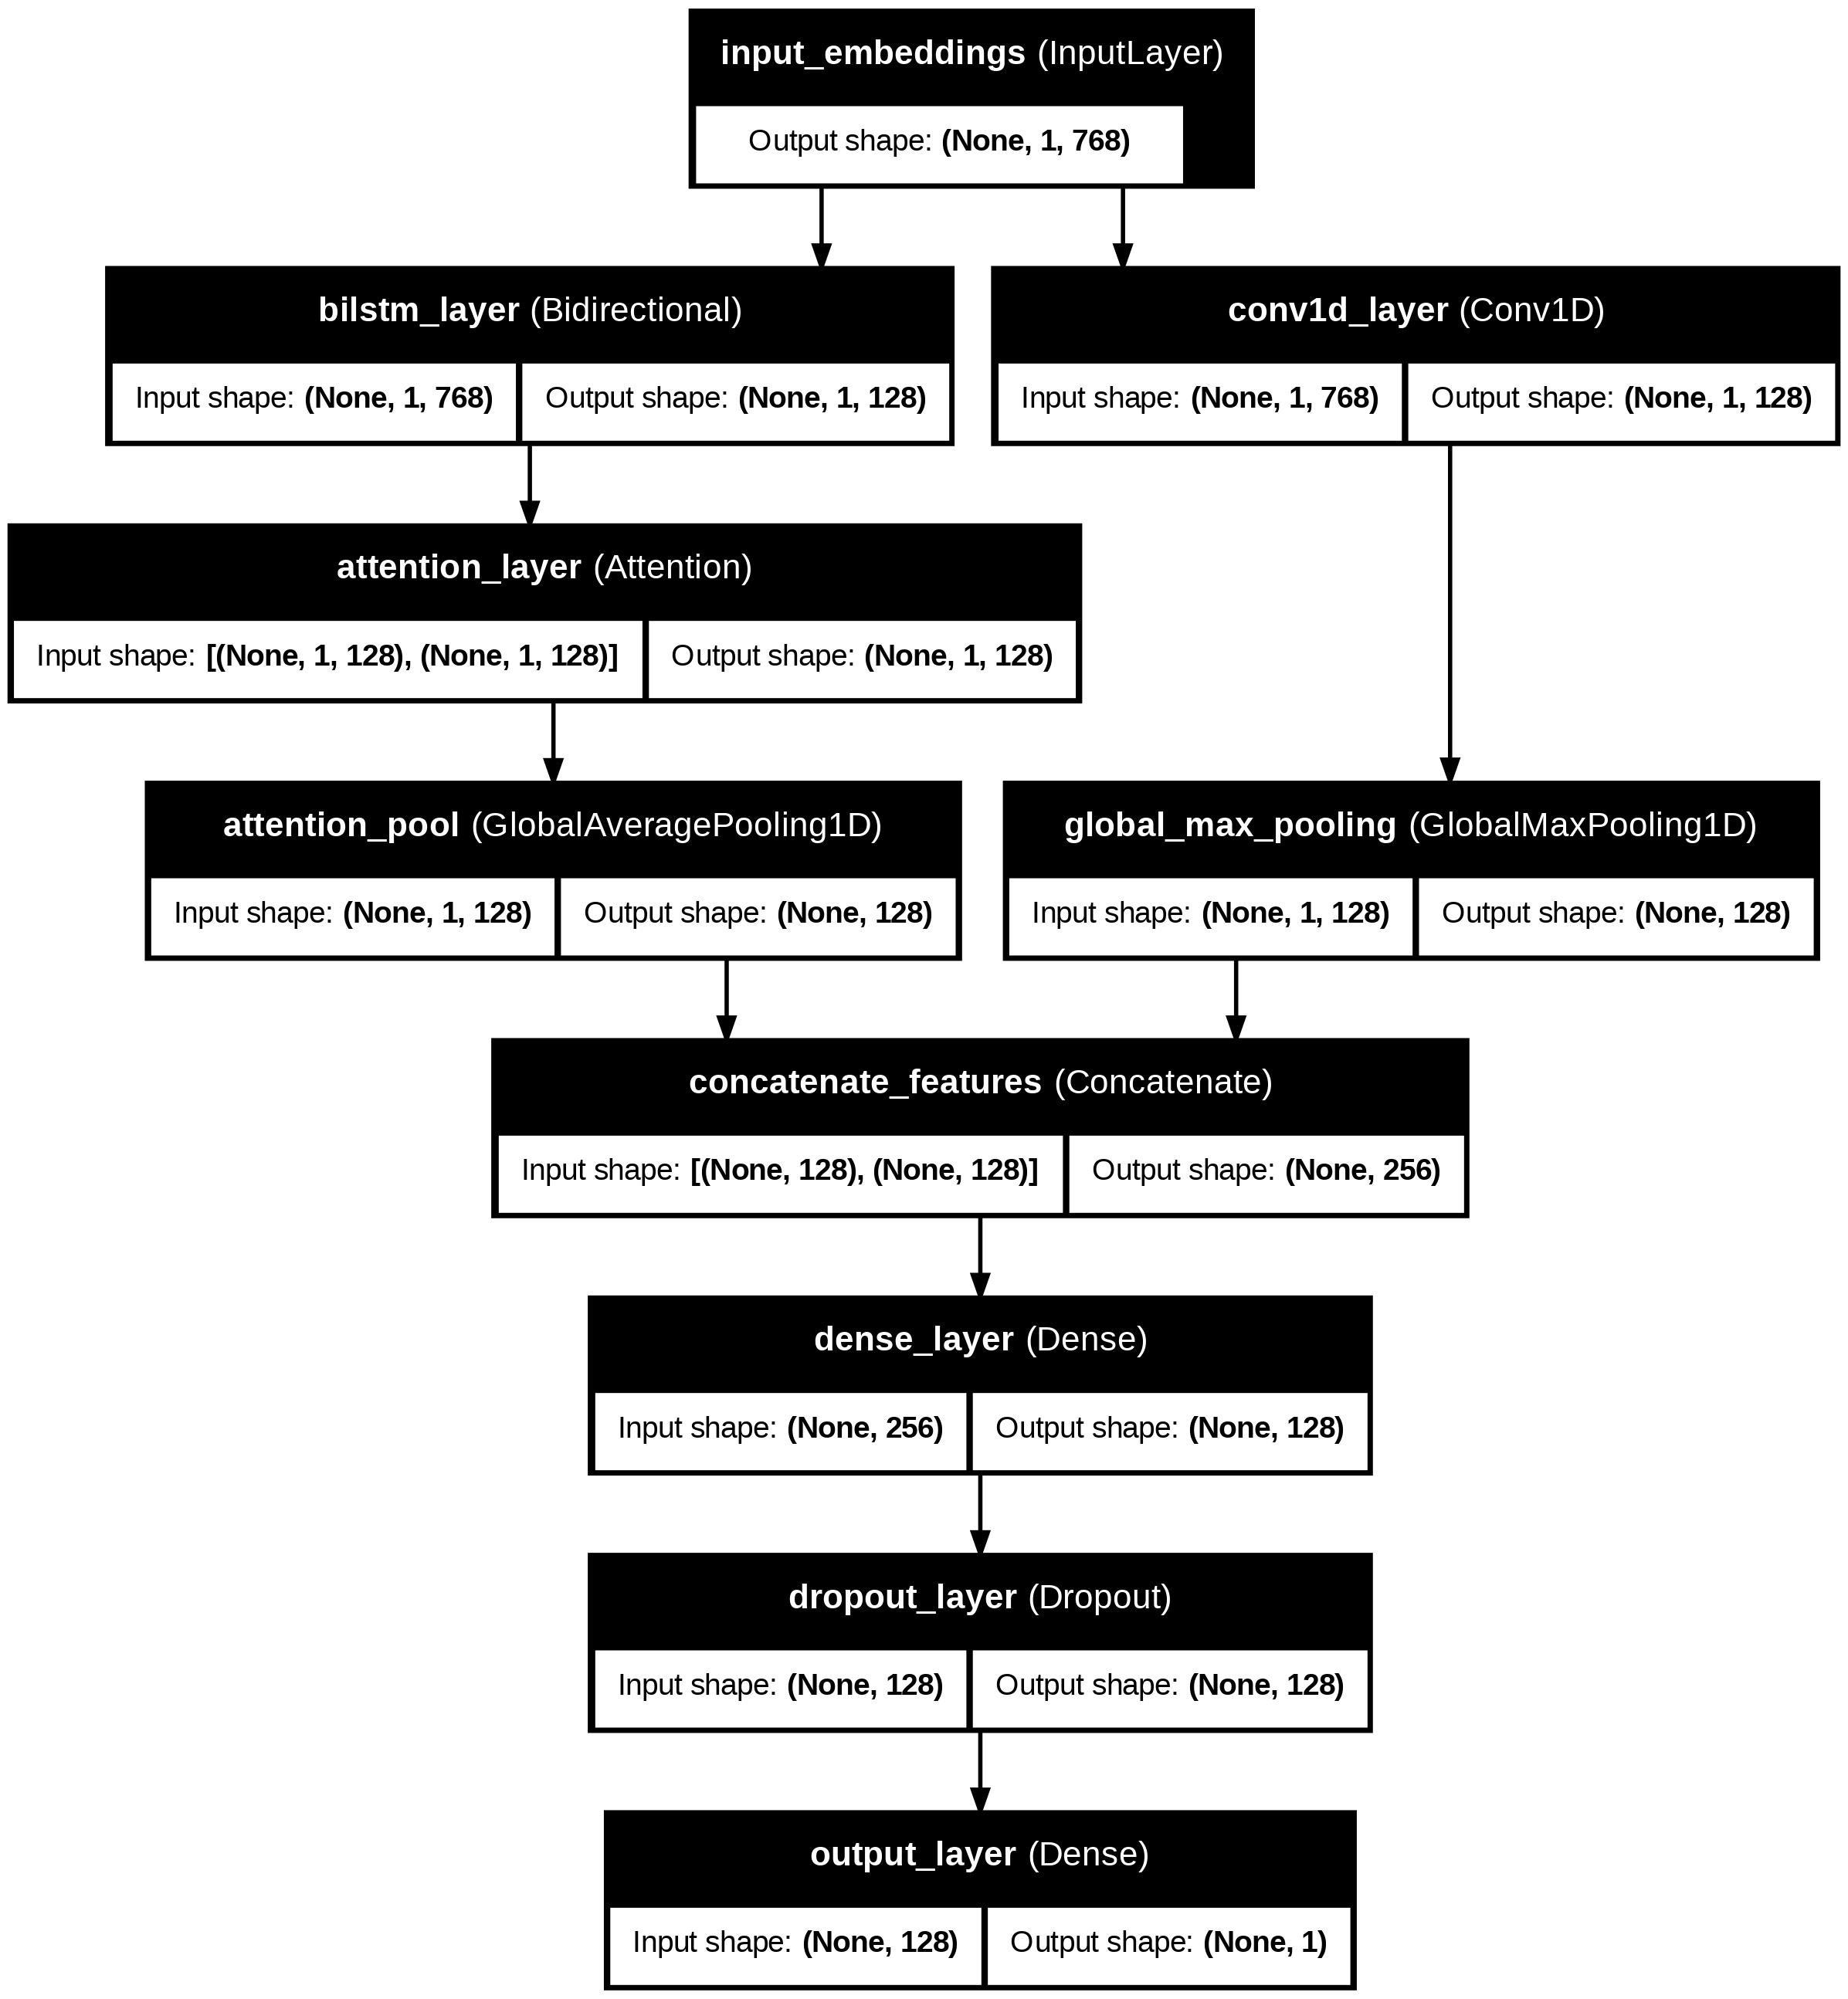

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')

## Entrenamiento del Modelo

 Configuramos:
 - Early stopping para evitar sobreajuste
 - Checkpointing para guardar mejores pesos
 - Reducción de learning rate en mesetas

In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    )
]

In [ ]:
# Entrenamiento
history = model.fit(
    X_train, y_train,
    class_weight=class_weights,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.6171 - auc: 0.6666 - loss: 0.6620 - precision: 0.6351 - recall: 0.5229 - val_accuracy: 0.8317 - val_auc: 0.8571 - val_loss: 0.5472 - val_precision: 0.7143 - val_recall: 0.7692 - learning_rate: 1.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6823 - auc: 0.7288 - loss: 0.6030 - precision: 0.7384 - recall: 0.5521 - val_accuracy: 0.7788 - val_auc: 0.8658 - val_loss: 0.5149 - val_precision: 0.6145 - val_recall: 0.7846 - learning_rate: 1.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7102 - auc: 0.7845 - loss: 0.5512 - precision: 0.7468 - recall: 0.6232 - val_accuracy: 0.8413 - val_auc: 0.8797 - val_loss: 0.4505 - val_precision: 0.7581 - val_recall: 0.7231 - learning_rate: 1.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7202 - auc: 0.7888 - loss: 0.5497 - precision: 0.7718 - recall: 0.6306 - val_accuracy: 0.8029 - val_auc: 0.8836 - val_l

## Evaluación y Análisis de Resultados

 1. Curvas de aprendizaje
 2. Métricas de clasificación
 3. Matriz de confusión
 4. Interpretabilidad con atención

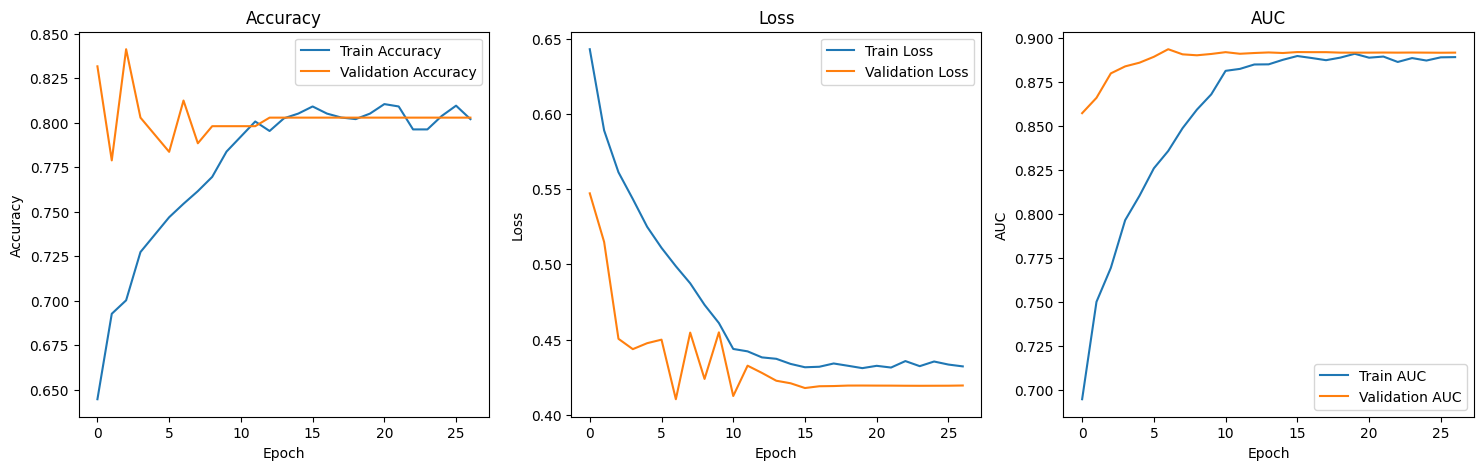

In [ ]:
# Visualizar curvas de aprendizaje
def plot_training_history(history):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Loss
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()

    # AUC
    axs[2].plot(history.history['auc'], label='Train AUC')
    axs[2].plot(history.history['val_auc'], label='Validation AUC')
    axs[2].set_title('AUC')
    axs[2].set_ylabel('AUC')
    axs[2].set_xlabel('Epoch')
    axs[2].legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history)

In [ ]:
# Evaluar con datos de prueba
test_results = model.evaluate(X_test, y_test, verbose=0)
print("\nResultados en conjunto de prueba:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")
print(f"AUC: {test_results[4]:.4f}")


Resultados en conjunto de prueba:
Loss: 0.4046
Accuracy: 0.8558
Precision: 0.7397
Recall: 0.8308
AUC: 0.9088


In [ ]:
# Predicciones y matriz de confusión
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_classes))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       143
           1       0.74      0.83      0.78        65

    accuracy                           0.86       208
   macro avg       0.83      0.85      0.84       208
weighted avg       0.86      0.86      0.86       208



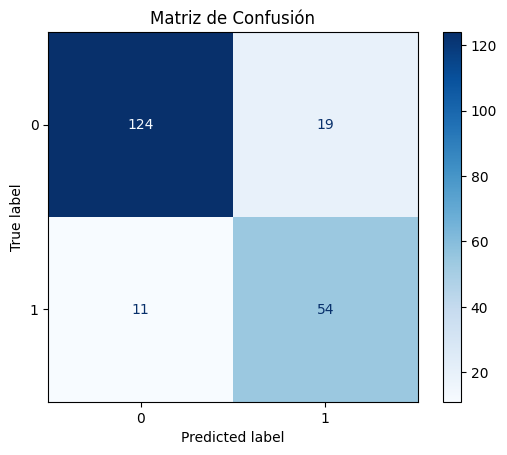

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
# Guardar modelo completo
model.save('fake_news_detector_final.keras')
print("Modelo guardado exitosamente!")

Modelo guardado exitosamente!


 ## Conclusiones

 Este notebook implementó un sistema completo para:
 1. Cargar embeddings preprocesados con RoBERTa
 2. Construir arquitectura híbrida CNN-BiLSTM con atención
 3. Entrenar con técnicas de regularización
 4. Evaluar con metricas de rendimiento

